# Detecting out of distribution images in Cifar10 using Annoy and AutoML

{{ badge }}

This example shows how to train a neural network image classifier via [AutoGluon AutoML](https://auto.gluon.ai/) and then leverage it for outlier detection with cleanlab. We also demonstrate how to perform outlier detection using feature embeddings with custom K-Nearest-Neighbor implementations beyond ``sklearn``. Here we demonstrate this with the efficient approximate neighbors library [Annoy](https://github.com/spotify/annoy), but a similar strategy can be used to leverage any other KNN library. 

You should be able to use the code here to find outliers in almost any image dataset.


## 1. Load required packages and set seeds for reproducibility

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from autogluon.vision import ImagePredictor, ImageDataset
from annoy import AnnoyIndex
from cleanlab.outlier import OutOfDistribution


SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Load the Cifar10 dataset

In [ ]:
experiment_path = "./experiment"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

In [ ]:
# Download CIFAR-10 data for model training
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Here is an alternative command to download the data from the source:
# cifar2png cifar10 ./data/cifar10_test --name-with-batch-index

# Import CIFAR-10 labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

In [4]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
    img = cv2.imread(img)[...,::-1]
    return img

def plot_images(image_paths):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X = image_paths[i]
        ax = plt.subplot(3,5,i+1)
        ax.imshow(imshow(X))
    plt.show()

Each image in the original cifar10 dataset belongs to 1 of 10 classes: `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`. After loading the data and processing the images, we manually remove some classes from the training dataset thereby making images from these classes outliers in the test dataset. Here we to remove all classes that are not an animal, such that test images from the following classes would be out-of-distribution: `[airplane, automobile, ship, truck]`.

In [5]:
# Load ground labels and image paths
labels = np.load(f'{experiment_path}/c10h_test_labels.npy')
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = np.array([f"{path}/{image_path}" for image_path in image_paths])

# Split CIFAR-10 dataset into train and test
trainx, testx, trainy, testy = train_test_split(image_paths, labels, test_size=0.15, random_state=SEED)

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainx = trainx[animal_idxs]
trainy = trainy[animal_idxs]

# Zip dataset into format accepted by autogluon
trainset = pd.DataFrame(zip(trainx,trainy), columns=["image", "label"])
testset = pd.DataFrame(zip(testx,testy), columns=["image", "label"])

print('Trainset length: %s' % (len(trainset)))
print('Testset length: %s' % (len(testset)))

Trainset length: 5099
Testset length: 1500


## 3. Train image classification model

Here we fit a neural network for image classification by applying [AutoGluon AutoML](https://auto.gluon.ai/) to our training data (that only contains animal classes).

In [ ]:
model_name = 'resnet18'  # Can train Swin Transformer instead of ResNet via: 'swin_base_patch4_window7_224'

model = ImagePredictor(verbosity=0)
model.fit(
    train_data=trainset,
    ngpus_per_trial=1,
    hyperparameters={"holdout_frac": 0.2, "model": model_name},
    time_limit=7200,  # you can control how long the AutoML trains for
    random_state=12345,
)

From the learned representations of this trained neural network, we can obtain numeric feature embeddings for each image in our datasets:

In [7]:
train_feature_embeddings = model.predict_feature(trainset['image'].to_list())["image_feature"].values
train_feature_embeddings = np.array(train_feature_embeddings.tolist())
test_feature_embeddings = model.predict_feature(testset['image'].to_list())["image_feature"].values
test_feature_embeddings = np.array(test_feature_embeddings.tolist())

## 4. Use cleanlab and `feature_embeddings` to find outliers in the dataset

By default, cleanlab uses the `sklearn.neighbors.NearestNeighbor` class (with *cosine* distance) to find the K nearest neighbors, but you can easily pass in another KNN estimator into cleanlab's `OutOfDistribution` class through its  `params` attribute. [Annoy](https://github.com/spotify/annoy) is an efficient approximate neighbors library that is much more scalable than `sklearn`, so let's use it instead. We simply wrap the Annoy neighbors object into a sklearn-compatible API:

In [8]:
class ApproxNearestNeighbors:
    """ Annoy class that is compatible with sklearn API. """
    def __init__(self, n_neighbors: int = 5, metric: str = "angular", n_trees: int = 10):
        self.ann_index = None
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.n_trees = n_trees
        
    def fit(self, features: np.array):
        dim = features.shape[1]
        self.ann_index = AnnoyIndex(dim, self.metric)
        for i, x in enumerate(features):
            self.ann_index.add_item(i, x)
        self.ann_index.build(self.n_trees)
        return self
    
    def kneighbors(self, features: np.array):
        distances = []
        indices = []
        for x in features:
            idx, dist = self.ann_index.get_nns_by_vector(x, self.n_neighbors, include_distances=True)    
            distances.append(dist)
            indices.append(idx)
        distances = np.array(distances)
        indices = np.array(indices)
        return distances, indices

We can then use this Annoy object to find the nearest neighbors of each image (in feature embedding space).

In [9]:
# Fit knn object on train_feature_embeddings
knn = ApproxNearestNeighbors()
knn.fit(train_feature_embeddings)

Then we can leverage this fitted KNN estimator with cleanlab's `OutOfDistribution` class to find outliers in the data. Below we compute an OOD score for each image in the training data where smaller values near 0 indicate images that are less typical under the data distribution (i.e. outliers). 

In [10]:
OOD = OutOfDistribution(params={"knn": knn})
train_ood_features_scores = OOD.score(features=train_feature_embeddings)

#### Top 15 atypical examples in the training data (based on outlier scores calculated from feature embeddings) 

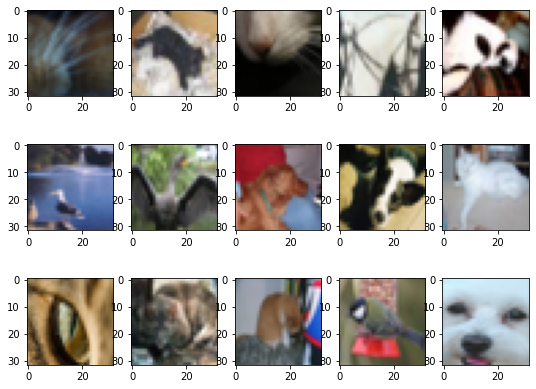

In [20]:
top_train_ood_features_idxs = train_ood_features_scores.argsort()[:15]
top_train_ood_features = trainset.iloc[top_train_ood_features_idxs]["image"].to_list()
plot_images(top_train_ood_features)

Recall our training data solely contains animal images, so these are the strangest looking creatures of the bunch! 
We can also compute out-of-distribution scores for each image in the additional test data, which measure how atypical each image is under the previous training data's distribution.

In [12]:
test_ood_features_scores = OOD.score(features=test_feature_embeddings)

#### Top 15 atypical examples in the test data (based on outlier scores calculated from feature_embeddings) 

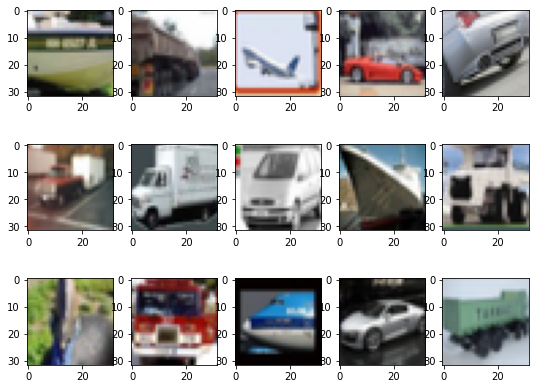

In [13]:
top_test_ood_features_idxs = test_ood_features_scores.argsort()[:15]
top_test_ood_features = testset.iloc[top_test_ood_features_idxs]["image"].to_list()
plot_images(top_test_ood_features)

Note that all the atypical examples belong to the out-of-distribution classes that were absent from our training set (which was entirely composed of animal images).

## 5. Use cleanlab and `pred_probs` to find outliers in the dataset

We sometimes wish to find outliers in classification datasets for which we do not have meaningful numeric feature representations. In this case, cleanlab can detect unusual examples in the data solely using predicted probabilities from a trained classifier. Here we train our same AutoML image classifier using cross-validation, which allows us to generate out-of-sample `pred_probs` for every example in the dataset. These are less biased reflections of the classifier's outputs on previously unseen images.

In [ ]:
from utils.model_training import train_model, sum_xval_folds

model_results_folder = "./experiment/model_training"
model_type = "resnet18"  # Can train Swin Transformer instead of ResNet via: "swin_base_patch4_window7_224"

train_args = {
    "num_cv_folds": 5, # decrease this value if you want code to run faster
    "verbose": 0, 
    "epochs": 50, # decrease this value if you want code to run faster
    "time_limit": 7200, # decrease this value if you want code to run faster
    "random_state": 123,
} 

model = train_model(model_type, trainset, model_results_folder, **train_args);

After training via cross-validation, we compute out-of-sample predicted class probabilities for every image in our training data (which only contained animal images).

In [15]:
train_pred_probs, labels, images = sum_xval_folds(model_type, model_results_folder, **train_args)

We also compute predicted probabilities for every image in the test data, here simply using the model from our final fold of cross-validation.

In [16]:
test_pred_probs = np.array(model.predict_proba(testset['image'].to_list()))

Now we can use cleanlab to score outliers based on `pred_probs` instead of feature embeddings. We MUST zero index our class labels to be integers from 0,1,...,K-1 in order for cleanlab to properly work!

In [17]:
# Zero index train labels
train_labels = trainset['label'].values
train_labels = np.unique(train_labels, return_inverse=True)[1]

# Compute outlier scores for train data (must fit OOD estimator)
OOD = OutOfDistribution()
train_ood_predictions_scores = OOD.fit_score(pred_probs=train_pred_probs, labels=train_labels)

# Compute outlier scores for test data (OOD estimator already fit)
test_ood_predictions_scores = OOD.score(pred_probs=test_pred_probs)

Fitting OOD estimator based on provided pred_probs ...


#### Top 15 atypical examples in the training data (based on outlier scores calculated from out-of-sample  `pred_probs`) 

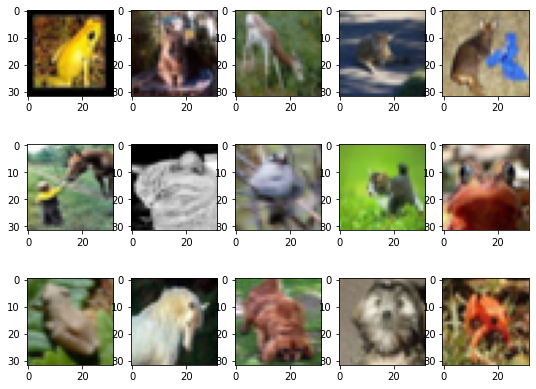

In [18]:
top_train_idxs = train_ood_predictions_scores.argsort()[:15]
top_train_images = trainset.iloc[top_train_idxs]["image"].to_list()
plot_images(top_train_images)

#### Top 15 atypical examples in the test data (based on outlier scores calculated from `pred_probs`)

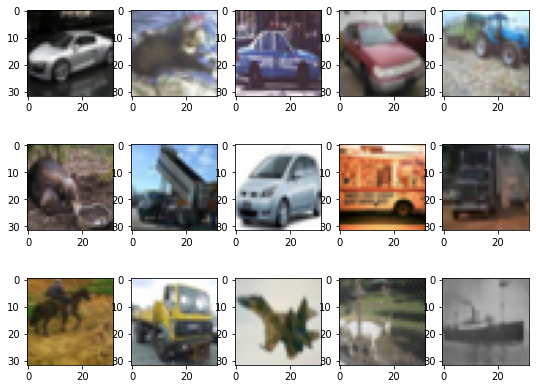

In [19]:
top_test_idxs = test_ood_predictions_scores.argsort()[:15]
top_test_images = testset.iloc[top_test_idxs]["image"].to_list()
plot_images(top_test_images)

Notice how most of these lowest scoring examples come from the out-of-distribution (non animal) classes.